In [8]:
using DataFrames, CSV, StatsPlots, Plots.Measures, Statistics, LaTeXStrings

# Handling data from the TI impurity simulations
In this notebook we want to show how the data files generated with our simulations for the two-dimensional Topological insulator with impurities can be handled to extract the desired information.

The simulation saves several .csv files, specifically it creates a folder named with the date and within that folder it creates 
* a log file with the parameters used for the simulation in the first line and several timestamped lines with the progress of the simulation for monitoring during running the code
* a number of .csv files that each contain the results of the simulation for one specific random impurity distribution

## The .log file

First we take a look at the log file.
For this purpose we read the first line of the .log from the data folder (small sample of an actuall results folder).

In [2]:
params = readline("data\\2020-12-12\\2020-12-12.log")

"[2020-12-12T00:52:56.573]: START V8 with parameters: V=1.0 , LolB=8.0 , M=0.2, Ms=0.0, Omega=2 , nmax=6 , Erange=-9.0:0.04:11.0, 1000 imp averaging runs "

Most relevant for us will be the biggest Fourier coefficient $n_{max}$, so we store it in a varible to use later.

In [3]:
nmax = parse(Int, first(split(last(split(params,"nmax="))," ,")))

6

We se the time stamp when the simulation started and with what parameters.
Note that one folder is created for each set of parameters, so this line can be used to automate the extraction of parameters and looping over several folders can be used to compare between parameters.

If we look at the second line we see that it logged that 10 runs where completed.
This is logged purely for information and monitoring purposes during the runs (the runs on a poweful desktop computer ran depending on parameters between several minutes to several days).

In [4]:
readlines("data\\2020-12-12\\2020-12-12.log")[2]

"[2020-12-12T00:58:34.139]: Transmission run 10 completed "

## The .csv files

The .csv files contain the results of the simultaion for one specific impurity configuration.
More specifically it contains

* the energy grid that will be the x-axis of most plots
* all calculated Green's function components that appear in the Floquet scattering matrix of the problem
* the Density of states at the impurity closest to the center
* the Density of states at the center of the impurity region
* the transmission from the left to the right end of the impurity region (T_RL)
* the transmission from the right to the left end of the impurity region (T_LR)

In principle the transmissions and density of states can be calculated from the Green's function components, but for convenience this has already been done.

Now let's load up one of the .csv files.
Note, that the Green's function components are complex numbers, so we specify the types for the columns.
The first two columns are going to be Floats, followed by $6 \cdot (2 n_{max}+1)$ ComplexFloats (6 for components between left and right, right and left, left and left, right and right, two times from center to center (spin) and $(2 n_{max}+1)$ for $n_{max}$ Fourier components positive/negative and zero) and the remaining three columns are Floats again.

In [5]:
df=DataFrame(CSV.File("data\\2020-12-12\\2020-12-12_1.csv",types=[Float64, Float64, [Complex{Float64} for i=1:(2*nmax+1)*6]...,Float64, Float64, Float64]))
first(df,5) # show only first 5 rows

,E,DOS_centerimp,G-6RLuu,G-5RLuu,G-4RLuu
,Float64,Float64,Complex…,Complex…,Complex…
1,-9.0,1.02171,0.0145235-0.0156767im,0.000353173+0.0158911im,0.0167422+0.0364073im
2,-8.96,0.954799,0.0219064-0.0062951im,-0.00729059+0.0146443im,-0.00285381+0.041375im
3,-8.92,0.906757,0.0230521+0.00658856im,-0.0139876+0.00983321im,-0.0232726+0.0355674im
4,-8.88,0.879691,0.0162852+0.0185703im,-0.0177693+0.0015771im,-0.0378348+0.0198754im
5,-8.84,0.870341,0.00334956+0.0247086im,-0.016431-0.00817607im,-0.0424468-0.000586871im


# Impurity averaging
We can now read the data for one specific impurity configuration.
Since we want to do impurity averaging we need to read the other files in the folder and in this case we will append them all to the same DataFrame and add a seris index for each series.
We will use the number appended to the filename to number the configurations.

In [6]:
files = filter(x -> x[end-3:end] == ".csv", readdir("data\\2020-12-12\\")) # create vector containing the filenames
data = DataFrame() # initialize empty dataframe
for i in files # loop over files
    # prepare dataframe
    df = DataFrame(CSV.File("data\\2020-12-12\\"*i,types=[Float64, Float64, [Complex{Float64} for i=1:(2*nmax+1)*6]...,Float64, Float64, Float64])) # read the .csv as dataframe
    s = parse(Int,last(split(first(split(i,'.')),'_'))) # extract series number from filename
    df[!, :series] = [s for k in 1:size(df)[1]] # label series in dataframe, could also add potential or other things
    # append the prepared df to main dataframe
    append!(data,df)
end

Our goal is now get the impurity averaged transmission (from left to right) and also the density of states at the center depending on the energy.
We can get that by simply grouping the data by the energy, i.e. get separate DataFrames for every energy and use the combine function to average and combine into the data we are interested in
(This follows the split-apply-combine logic, further reading [here](https://dataframes.juliadata.org/stable/man/split_apply_combine/)).

In [7]:
gdf = groupby(data,:E)
result = combine(gdf,:T_RL => mean, :DOS => mean)
first(result,5) # show only first 5 rows

LoadError: UndefVarError: mean not defined

We can save the resulting dataframe as a .csv using the CSV package.

In [8]:
CSV.write("impavg.csv",result)

"impavg.csv"

## Plots
To plot the prepared data we can use the plot recipies that the StatPlots-Package provides

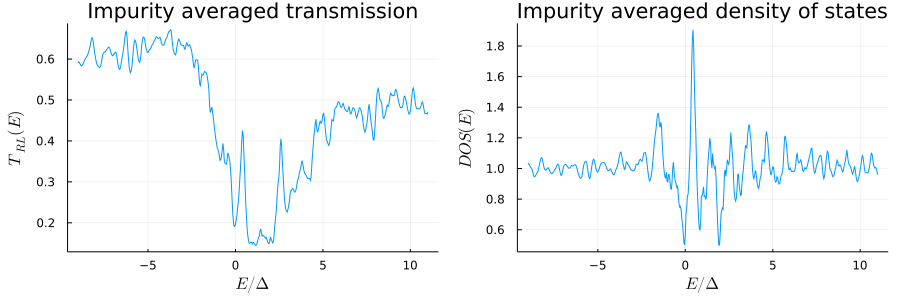

In [32]:
plt1 = begin
    # plot reciept for initial plot
    @df result plot(:E,:T_RL_mean)
    # refine plot
    plot!(legend = false, xlabel = L"E/\Delta", ylabel = L"T_{RL}(E)")
    plot!(title = "Impurity averaged transmission")
end
plt2 = begin
    # plot reciept for initial plot
    @df result plot(:E,:DOS_mean)
    # refine plot
    plot!(legend=false,xlabel=L"E/\Delta",ylabel=L"DOS(E)")
    plot!(title = "Impurity averaged density of states")
end
# composite plot with the two plots prepared above
plot(plt1, plt2, layout = (1,2), size = (900,300), left_margin = [5mm 5mm], bottom_margin = [5mm 5mm])

Now we may want to see the difference between the impurity averaged results and the non-averaged traces.
For that we can group the data by the series index we added earlier and plot those traces.

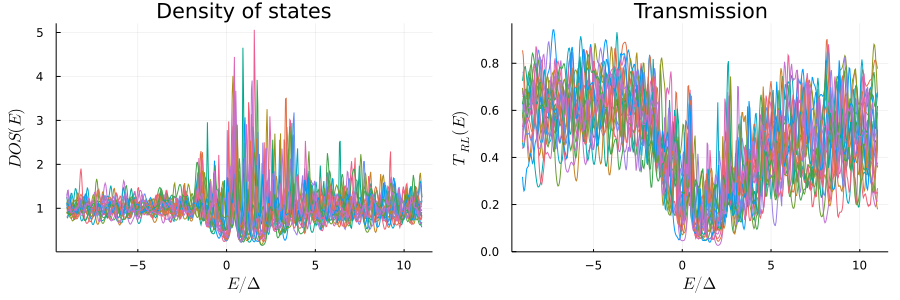

In [33]:
plt1 = begin
    plot() # initialize plot canvas
    for i in groupby(data,:series) # loop over the series in our dataframe
        @df i plot!(:E,:DOS) 
    end 
    # refine plot
    plot!(legend=false,xlabel=L"E/\Delta",ylabel=L"DOS(E)")
    plot!(title = "Density of states")
end
plt2 = begin
    plot() # initialize plot canvas
    for i in groupby(data,:series) # loop over the series in our dataframe
        @df i plot!(:E,:T_RL) # add the series to the canvas
    end
    # refine plot
    plot!(legend=false,xlabel=L"E/\Delta",ylabel=L"T_{RL}(E)")
    plot!(title = "Transmission")
end
# composite plot with the two plots prepared above
plot(plt1, plt2, layout = (1,2), size = (900,300), left_margin = [5mm 5mm], bottom_margin = [5mm 5mm])

To understand the effect the impurity averaging has we can also plot a few non-averaged traces next to the averaged results.
For that we can make use of the layout macro for more complicated composite plots and also the series index we added to the data earlier.

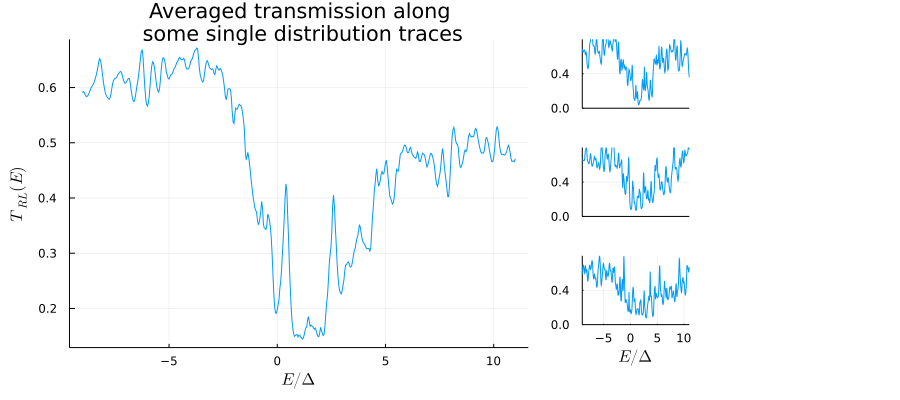

In [66]:
l = @layout([a{0.6w} [b{0.35w,0.3h}; c{0.35w,0.3h}; d{0.35w,0.3h}]]) # set the layout
# create 3 single distribution plots
single=[] # initialize containter for subplots
for i in 1:3 
    d = groupby(data,:series)[i] # group data by series
    push!(single,@df d plot(:E,:T_RL,legend = false, widen = false, ylims = (0.,0.8),yticks=[0.0,0.4])) # append plot to container
    # some layouting depending on final position in the plot
    if i == 1
        plot!(xticks=[], top_margin = 8mm)
    elseif i == 2
        plot!(xticks=[])
    else
        plot!(xlabel = L"E/\Delta")
    end
end
# impurity averaged plot
avg = @df result plot(:E,:T_RL_mean,legend = false, xlabel = L"E/\Delta", ylabel = L"T_{RL}(E)",left_margin = [5mm 5mm], title = "Averaged transmission along\n some single distribution traces")
# final plot
plot(avg,single...,layout = l,size=(900,400),bottom_margin = 5mm)